Code provides a basic framework for method implementation as well as giving examples on how to calculate benchmarks. In a true study, like the paper, the tests at the end would be ran thousands of times with new demand test sets generated each time. Then a and b would be regenerated for hundreds of simulations to create new instances which then run on hundreds of generated test sets.

In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from gurobipy import *
from sys import stdout
import pickle
import random
test = Model() # Stop gurobi licence repeating

Academic license - for non-commercial use only - expires 2022-10-10
Using license file C:\Users\loweryb\gurobi.lic


## Demand Generation

In [2]:
# Function to generate demand

# a: factors on price
# b: demand curve
# CV: coefficiant of variation
# p: number of data points
# p_range: range to draw price from
# seed: Random seed, default 45
# thresh: proportion of negative values allowed, default 0.05 (5%)

def generateDemand(a,b,CV,p,p_range,seed=42, thresh=0.05):
    np.random.seed(seed)

    
    # Generate selling prices, rounded to 2dp.
    SP = np.round(np.random.uniform(p_range[0],p_range[1],p),2)
    
    # calculate mean and Recover std.
    mu=np.mean(a-b*SP)
    
    sigma=CV*mu
    
    # Add random demand.
    eps=np.random.normal(0,sigma, p)
    
    # Generate demand 
    demand=a-b*SP+eps
    
    # (check too no more than 5% <0)
    if ((demand<0).sum()>p*thresh):
        print("Too many negatives > {price:.2f}%".format(price = thresh*100))
        print((demand<0).sum())
        return 0,0
    
    # Replace negatives with 0
    demand[demand<0]=0
    
    return SP, demand

# Methodology
========================

 ## Method of Moments

In [10]:
def MM(demand_obvs, CF):
    # Assume normal means sample moments are just same as MLE in case of MM
    mu_hat=np.mean(demand_obvs)
    sigma_hat=np.std(demand_obvs)
    
    # Calculate optimal Quantity
    Q_hat=stats.norm.ppf(CF,mu_hat,sigma_hat)
    
    return mu_hat, sigma_hat, Q_hat

## SAA

In [11]:
def SAA(demand_obvs, CF):
    # ECDF is equivalent to sorting the demand observations then return the CF quantile
    
    demand_sorted=np.sort(demand_obvs)
    
    # Optimal order quantity is the CF quantile 
    Q_hat = np.quantile(demand_sorted, q=CF)
    return Q_hat

## Scarf's Min-Max Rule

In [12]:
def SR(demand_obvs, u, o):
    
    # Calculate sample moments
    mu_hat = np.mean(demand_obvs)
    sigma_hat=np.std(demand_obvs)
    
    Q_hat=mu_hat+sigma_hat/2*(np.sqrt(u/o)-np.sqrt(o/u))
    
    return Q_hat

## Feature Cost

In [13]:
def BM(p, d, u, o):
    # Params: price, demand, underage, overage
    # Assumes 1 feature, n points
    n=len(p)
    
    m = Model()
    m.setParam('OutputFlag', False)
    
    # Add decision variables 
    q=m.addVars(2, lb=-GRB.INFINITY)
    v=m.addVars(n, lb=0)
    s=m.addVars(n, lb=0)
    
    # Add objective function
    obj=quicksum(o*v[i]+u*(d[i]-s[i]) for i in range(n))
    m.setObjective(obj,GRB.MINIMIZE)
    
    # Add constraints
    for i in range(n):
        m.addConstr(q[0]+q[1]*p[i]-d[i]<= v[i])
        m.addConstr(s[i] <=d[i])
        m.addConstr(s[i] <= q[0]+q[1]*p[i])
    
    # optimise problem
    m.optimize()
    
    # Return parameters (optimal order Q=q_0+q_1*p)
    return q[0].x, q[1].x

## Actual

In [14]:
def true_val(a,  b, CV, CF):
    # True: a-bp+F^-1(CF)*sigma
    sigma=CV*(a-b*0.5) # CV*mu, mean price p is 0.5
    coeff_a=a+sigma*stats.norm.ppf(CF,0,1)
    coeff_b=b
    return coeff_a, coeff_b

# Example Usage
==========================

In [19]:
# Variables
u=9
o=1
CF=u/(u+o) # Critical Fractile
CV=0.3 # Coefficiant of Variation
a=np.random.uniform(1000,2000,1)
b=np.random.uniform(300,500,1)
samples = 100000

In [53]:
# Price Generation
price, demand = generateDemand(a,b,CV,100000, [0,1], seed=42)

# Split into test and training sets, train on 100 samples say
demand_train=demand[:100]
demand_test=demand[100:]
price_train=price[:100]
price_test=price[100:]

In [54]:
# Create decision rules

# Method of Moments
Q_MM=MM(demand_train, CF)

# Sample Average approximation
Q_SAA=SAA(demand_train, CF)

# Scarf's Rule
Q_SR=SR(demand_train, u,o)

# Feature LP coefficiants
coef_FLP=BM(price_train, demand_train, u,o)

# Known coefficients
coef_known=true_val(a, b, CV, CF)

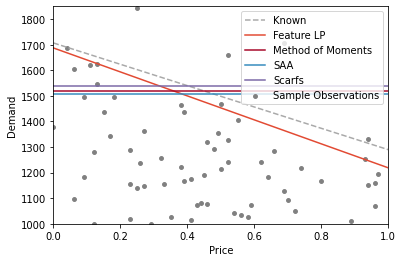

In [55]:
# Plot decision lines

# Plot training set
plt.scatter(price_train, demand_train, s=15, label='Sample Observations', color='grey')

points = np.linspace(0,1,100)

# Plot actual
plt.plot(points, coef_known[0]-coef_known[1]*points, color='darkgray', linestyle='--', label='Known')

# Plot Feature method
plt.plot(points, coef_FLP[0]+coef_FLP[1]*points, color='#E24A33',linestyle='-', label='Feature LP')

# Plot Featureless methods
plt.axhline(y=Q_MM[2], linestyle='-',color='#A60628', label='Method of Moments')
plt.xlabel('Price')
plt.ylabel('Demand')
plt.axhline(y=Q_SAA, linestyle='-',color='#348ABD',  label='SAA')
plt.axhline(y=Q_SR, linestyle='-',color='#7A68A6', label='Scarfs')
plt.axis([0, 1, 1000, 1850])
plt.legend()
plt.show()

# Example Benchmark Test 

## Service Levels

In [56]:
# Calculate Service levels on test set (single sim)

# Method of Moments
SL_MM=1-((demand_test>Q_MM[2]).sum())/100000

# SAA
SL_SAA=1-((demand_test>Q_SAA).sum())/100000

# Scarf's
SL_scarf=1-((demand_test>Q_SR).sum())/100000

# Feature LP
counter_SL_feature=0
for price_point, demand_point in zip(price_test,demand_test):
    feature_lp=coef_FLP[0]+coef_FLP[1]*price_point
    if (demand_point-feature_lp>=0):
        counter_SL_feature+=1
SL_featureLP=1-counter_SL_feature/100000

In [57]:
{'MM': SL_MM, 'SAA': SL_SAA, 'SR': SL_scarf, 'FLP': SL_featureLP}

{'MM': 0.8970899999999999, 'SAA': 0.89009, 'SR': 0.90482, 'FLP': 0.87347}

## Average Inventory Levels

In [58]:
# Calculate Average inventory levels on test set (single sim)

# Method of Moments
AI_MM=np.mean([Q_MM[2]-i for i in demand_test])

# SAA
AI_SAA=np.mean([Q_SAA-i for i in demand_test])

# Scarf's
AI_scarf=np.mean([Q_SR-i for i in demand_test])

# Feature LP
AI_FLP_tots=[]
AI_known_tots=[]
for price_point, demand_point in zip(price_test,demand_test):
    feature_lp=coef_FLP[0]+coef_FLP[1]*price_point
    known=coef_known[0]-coef_known[1]*price_point
    AI_FLP_tots.append(feature_lp-demand_point)
    AI_known_tots.append(known-demand_point)
AI_FLP=np.mean(AI_FLP_tots)
AI_known=np.mean(AI_known_tots)

In [59]:
{'MM': AI_MM, 'SAA': AI_SAA, 'SR': AI_scarf, 'FLP': AI_FLP, 'Known': AI_known}

{'MM': 437.9349276945117,
 'SAA': 425.25720192277777,
 'SR': 454.54270394676786,
 'FLP': 371.1950037732718,
 'Known': 416.4306185257121}